In [2]:
!pip install opendatasets
!pip install tensorflow
!pip install transformers
!pip install datasets
!pip install pandas
!pip install sklearn
!pip install numpy
!pip install keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=0694d609f3fa0134dc88e0971473c164d0385fb22a23e7966d483fb3f8771952
  Stored in directory: /root/.cache/pip/wheels/aa/9c/60/f67813603a52fc35057868f1aba0003cc75b72583dcaa2c341
Successfully built sklearn


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
import tensorflow_datasets as tfds
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import gc
import os
import opendatasets as od
import pandas as pd
from PIL import ImageFile, Image
from pathlib import Path
import cv2
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from glob import glob
import numpy as np
import pathlib
from sklearn.model_selection import train_test_split

In [4]:
od.download("https://www.kaggle.com/datasets/nicolasrr749/fruits-10-image-classification")

100%|██████████| 124M/124M [00:01<00:00, 83.6MB/s]


In [5]:

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Constants for image size and batch size
IMG_SIZE = (100, 100)  # Example size, adjust as needed
BATCH_SIZE = 32

# Function to load and preprocess image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0  # Normalize to [0,1]
    return image

In [6]:
file_names = []
labels = []
base_dir = '/content/fruits-10-image-classification/fruits-10/train'
# Iterate through all image files in the specified directory and its subdirectories
# Iterate through all image files in the specified directory and its subdirectories
for file in sorted((Path(base_dir).rglob('*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Convert labels to integers
#label_mapping = {label: i for i, label in enumerate(set(labels))}
#labels = [label_mapping[label] for label in labels]

# Print the total number of file names and labels
print(len(file_names), len(labels))


4000 4000


In [7]:
# Create a pandas dataframe from file names and labels
df = pd.DataFrame({"image": file_names, "label": labels})

# Random Oversampling //Data Augmentation but clonning
# ros = RandomOverSampler(random_state=83)
# df_resampled, labels_resampled = ros.fit_resample(df[['image']], df['label'])

# # Update DataFrame with resampled data
# df = pd.DataFrame({"image": df_resampled['image'], "label": labels_resampled})

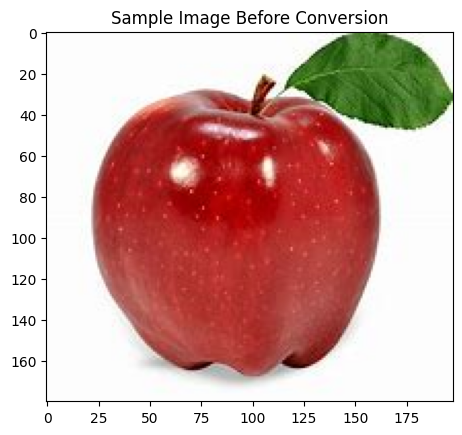

In [8]:
# Select a sample image from the DataFrame
sample_image_path = df['image'].iloc[0]

# Load and display the sample image
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.title("Sample Image Before Conversion")
plt.show()

In [9]:
df['label']

0           apple
1           apple
2           apple
3           apple
4           apple
          ...    
3995    raspberry
3996    raspberry
3997    raspberry
3998    raspberry
3999    raspberry
Name: label, Length: 4000, dtype: object

In [10]:
def one_hot_encode(label):
  temp = np.zeros(11)
  label2idx = {'apple': 0, 'avocado': 1,'banana': 2,'coconut': 3,'grape': 4,'mango': 5,'papaya': 6,'pineapple': 7,'rambutan': 8,'raspberry': 9}
  if label in label2idx:
    temp[label2idx.get(label)] = 1
  else:
    temp[-1] = 1
  #tensor = tf.convert_to_tensor(temp)
  #print(tensor)
  return temp

In [11]:
# Apply one-hot encoding to the 'label' column
df['encoded_label'] = df['label'].apply(one_hot_encode)

In [12]:
df

,image,label,encoded_label
0,/content/fruits-10-image-classification/fruits...,apple,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,/content/fruits-10-image-classification/fruits...,apple,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/content/fruits-10-image-classification/fruits...,apple,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,/content/fruits-10-image-classification/fruits...,apple,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,/content/fruits-10-image-classification/fruits...,apple,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
3995,/content/fruits-10-image-classification/fruits...,raspberry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3996,/content/fruits-10-image-classification/fruits...,raspberry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3997,/content/fruits-10-image-classification/fruits...,raspberry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3998,/content/fruits-10-image-classification/fruits...,raspberry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
df['encoded_label']

0       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
3995    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3996    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3997    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3998    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3999    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: encoded_label, Length: 4000, dtype: object

In [14]:
# Perform the train-test split
train_df, test_df = train_test_split(df, test_size=0.05, stratify=df['label'])

In [15]:
# Convert the DataFrames to TensorFlow datasets
def df_to_dataset(dataframe, shuffle=True, batch_size=32, prefetch=True):
    dataframe = dataframe.copy()
    labels = np.stack(dataframe['encoded_label'].values)  # Ensure labels are in a proper numpy array format

    ds = tf.data.Dataset.from_tensor_slices((dataframe['image'].values, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)  # Add parallel calls for efficiency
    ds = ds.batch(batch_size)

    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds\

# Convert to TensorFlow datasets
train_data = df_to_dataset(train_df, batch_size=BATCH_SIZE)
test_data = df_to_dataset(test_df, batch_size=BATCH_SIZE)

# Garbage collection
gc.collect()

3776

Encoded label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Numerical Tensor Representation of the Image:
 [[[0.07450981 0.34901962 0.00392157]
  [0.07843138 0.3529412  0.00784314]
  [0.08134461 0.35585442 0.01075637]
  ...
  [0.15383185 0.5381456  0.21265538]
  [0.14699106 0.5313048  0.20581459]
  [0.15056863 0.5152745  0.19762745]]

 [[0.07523529 0.3497451  0.00464706]
  [0.07962029 0.3541301  0.00903206]
  [0.08277009 0.3572799  0.01218186]
  ...
  [0.12019607 0.5045098  0.1790196 ]
  [0.11448301 0.49879673 0.17330652]
  [0.12186275 0.48656863 0.16892157]]

 [[0.07843138 0.3529412  0.00784314]
  [0.08290735 0.35741714 0.01231912]
  [0.08623284 0.36074263 0.01564461]
  ...
  [0.12333332 0.50764704 0.18215685]
  [0.1138877  0.49820143 0.17271122]
  [0.125      0.4897059  0.17205882]]

 ...

 [[0.95306355 0.9468366  0.9449595 ]
  [0.9298719  0.96823967 0.7870889 ]
  [0.6494273  0.754246   0.33154204]
  ...
  [0.7602632  0.736371   0.7640867 ]
  [0.9312033  0.9107097  0.9285027 ]
  [0.97765833 0.

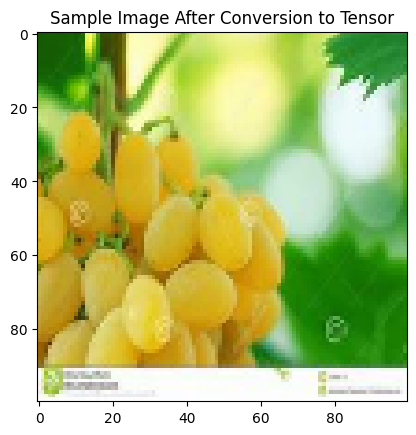

In [16]:
# Take one batch from the dataset
for images, labels in train_data.take(1):
    # Extract the first image tensor from the batch
    tensor_image = images[0]
    tensor_label = labels[0]

    print(f"Encoded label: {tensor_label}")

    print(f"Numerical Tensor Representation of the Image:\n {tensor_image}\n")

    print(f"Dimension and shape of the tensor: {tensor_image.ndim},{tensor_image.shape}" )


    # Convert the tensor to a numpy array and display it
    plt.imshow(tensor_image.numpy())
    plt.title("Sample Image After Conversion to Tensor")
    plt.show()

    # Break the loop after the first batch
    break

In [17]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])
val_data = df_to_dataset(val_df, batch_size=BATCH_SIZE)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))  # Assuming 11 classes including the 'other' class

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=val_data)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')




Epoch 1/25
119/119 [==============================] - 20s 34ms/step - loss: 1.9224 - accuracy: 0.2968 - val_loss: 1.6356 - val_accuracy: 0.4175
Epoch 2/25
119/119 [==============================] - 3s 27ms/step - loss: 1.4441 - accuracy: 0.5137 - val_loss: 1.1951 - val_accuracy: 0.6075
Epoch 3/25
119/119 [==============================] - 5s 46ms/step - loss: 1.1982 - accuracy: 0.5958 - val_loss: 1.0412 - val_accuracy: 0.6625
Epoch 4/25
119/119 [==============================] - 3s 28ms/step - loss: 1.0345 - accuracy: 0.6555 - val_loss: 0.9214 - val_accuracy: 0.7088
Epoch 5/25
119/119 [==============================] - 6s 53ms/step - loss: 0.8749 - accuracy: 0.7084 - val_loss: 0.7183 - val_accuracy: 0.7763
Epoch 6/25
119/119 [==============================] - 3s 27ms/step - loss: 0.7522 - accuracy: 0.7526 - val_loss: 0.6906 - val_accuracy: 0.7887
Epoch 7/25
119/119 [==============================] - 5s 44ms/step - loss: 0.5948 - accuracy: 0.8013 - val_loss: 0.4384 - val_accuracy: 0.863

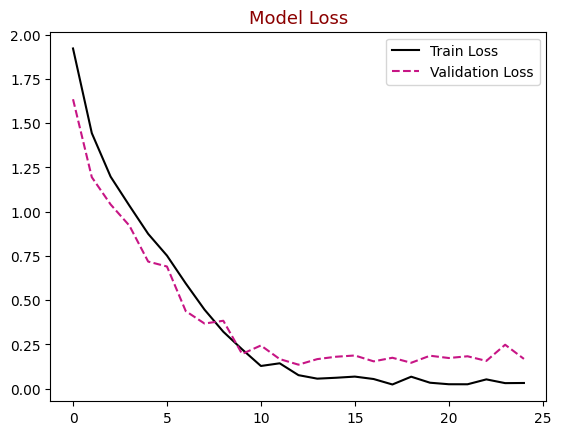

In [19]:
#Plotting train & validation loss
plt.figure()
plt.plot(history.history["loss"],label = "Train Loss", color = "black")
plt.plot(history.history["val_loss"],label = "Validation Loss", color = "mediumvioletred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Loss", color = "darkred", size = 13)
plt.legend()
plt.show()

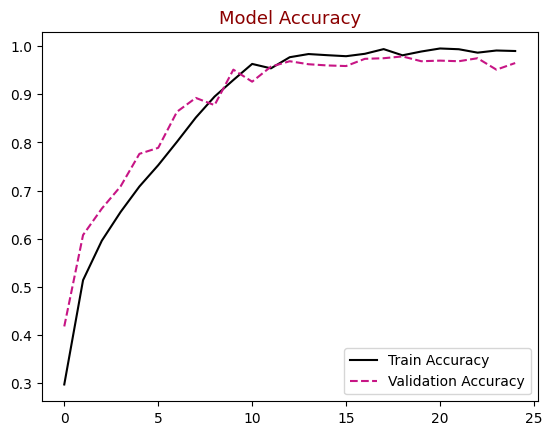

In [20]:
#Plotting train & validation accuracy
plt.figure()
plt.plot(history.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy", color = "mediumvioletred", linestyle="dashed",markeredgecolor = "purple", markeredgewidth = 2)
plt.title("Model Accuracy", color = "darkred", size = 13)
plt.legend()
plt.show()

# Stratified K-Fold

In [25]:
from sklearn.model_selection import StratifiedKFold
#import models
from tensorflow.keras import layers

# Define the number of folds
n_splits = 10
train_losses = []
val_losses = []
test_losses = []
# Create the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over the folds
for i, (train_index, val_index) in enumerate(skf.split(df, df['label'])):
    # Create training and validation datasets for this fold
    train_data_fold = df_to_dataset(df.iloc[train_index], batch_size=BATCH_SIZE)
    val_data_fold = df_to_dataset(df.iloc[val_index], batch_size=BATCH_SIZE)

    # Define the model
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(11, activation='softmax'))  # Assuming 11 classes including the 'other' class

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_data, epochs=25, validation_data=val_data)

    # Append training and validation loss
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_data)
    test_losses.append(test_loss)

    print(f'Fold {i+1}: Test Loss: {test_loss}, Test Accuracy: {test_acc}')

# After completing all folds, you can analyze the collected losses
print("Average Training Loss:", np.mean(train_losses))
print("Average Validation Loss:", np.mean(val_losses))
print("Average Test Loss:", np.mean(test_losses))

Epoch 1/25
119/119 [==============================] - 10s 41ms/step - loss: 1.9460 - accuracy: 0.2800 - val_loss: 1.6893 - val_accuracy: 0.3512
Epoch 2/25
119/119 [==============================] - 5s 45ms/step - loss: 1.5026 - accuracy: 0.4821 - val_loss: 1.2914 - val_accuracy: 0.5600
Epoch 3/25
119/119 [==============================] - 3s 28ms/step - loss: 1.2247 - accuracy: 0.5868 - val_loss: 1.1202 - val_accuracy: 0.6475
Epoch 4/25
119/119 [==============================] - 5s 40ms/step - loss: 1.0115 - accuracy: 0.6563 - val_loss: 0.8372 - val_accuracy: 0.7300
Epoch 5/25
119/119 [==============================] - 5s 39ms/step - loss: 0.8144 - accuracy: 0.7263 - val_loss: 0.6923 - val_accuracy: 0.7675
Epoch 6/25
119/119 [==============================] - 3s 27ms/step - loss: 0.6894 - accuracy: 0.7711 - val_loss: 0.6733 - val_accuracy: 0.7887
Epoch 7/25
119/119 [==============================] - 3s 28ms/step - loss: 0.4877 - accuracy: 0.8392 - val_loss: 0.4183 - val_accuracy: 0.865

In [26]:
import numpy as np

# Get the training and validation metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate the mean and standard deviation of the metrics
mean_train_acc = np.mean(train_acc)
std_train_acc = np.std(train_acc)
mean_val_acc = np.mean(val_acc)
std_val_acc = np.std(val_acc)
mean_train_loss = np.mean(train_loss)
std_train_loss = np.std(train_loss)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

# Print the results
print(f"Mean training accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Mean validation accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Mean training loss: {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Mean validation loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


Mean training accuracy: 0.8803 ± 0.1834
Mean validation accuracy: 0.8908 ± 0.1444
Mean training loss: 0.3529 ± 0.5149
Mean validation loss: 0.3659 ± 0.3879


7/7 [==============================] - 0s 16ms/step


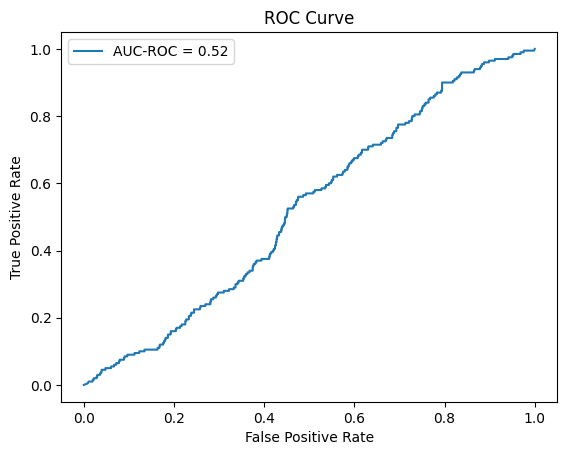

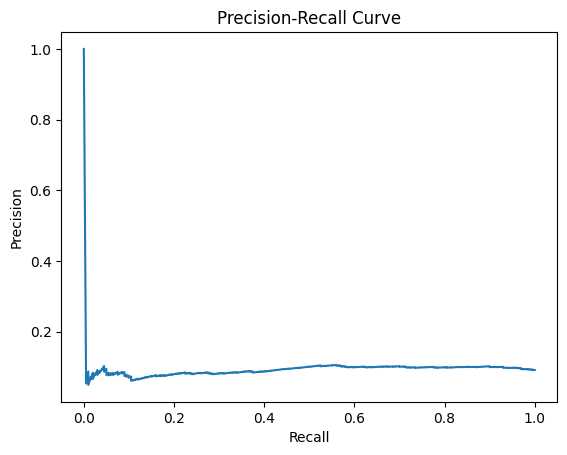

In [27]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the test set
y_pred = model.predict(test_data)

# Get the true labels for the test set
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())

# Calculate the precision, recall, and thresholds for the P-R curve
precision, recall, thresholds = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Calculate the AUC for the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot the P-R curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


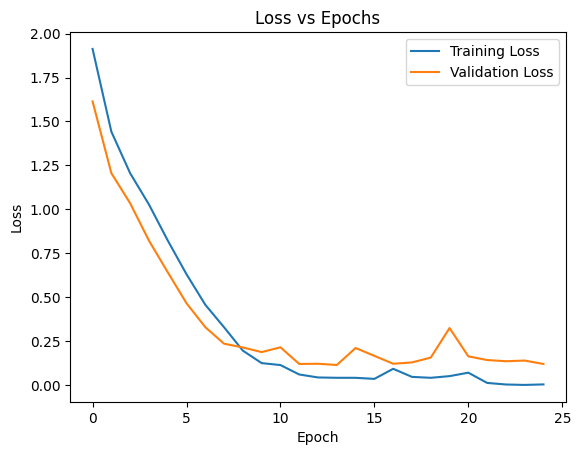

In [28]:
# Get the training and validation loss for each epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss vs epochs
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()


In [29]:
import numpy as np

# Get the training and validation metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calculate the mean and standard deviation of the metrics
mean_train_acc = np.mean(train_acc)
std_train_acc = np.std(train_acc)
mean_val_acc = np.mean(val_acc)
std_val_acc = np.std(val_acc)
mean_train_loss = np.mean(train_loss)
std_train_loss = np.std(train_loss)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

# Print the results
print(f"Mean training accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
print(f"Mean validation accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
print(f"Mean training loss: {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Mean validation loss: {mean_val_loss:.4f} ± {std_val_loss:.4f}")


Mean training accuracy: 0.8803 ± 0.1834
Mean validation accuracy: 0.8908 ± 0.1444
Mean training loss: 0.3529 ± 0.5149
Mean validation loss: 0.3659 ± 0.3879


7/7 [==============================] - 0s 16ms/step


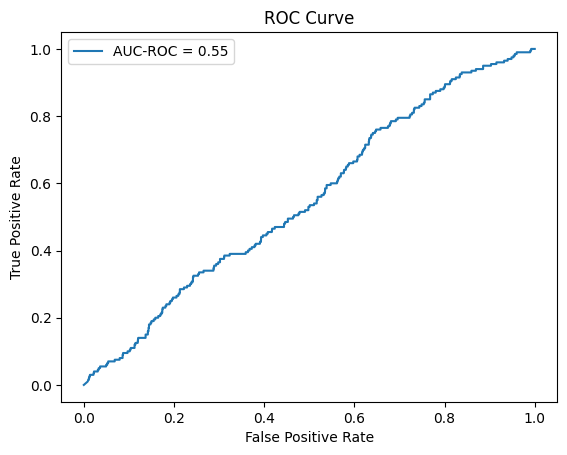

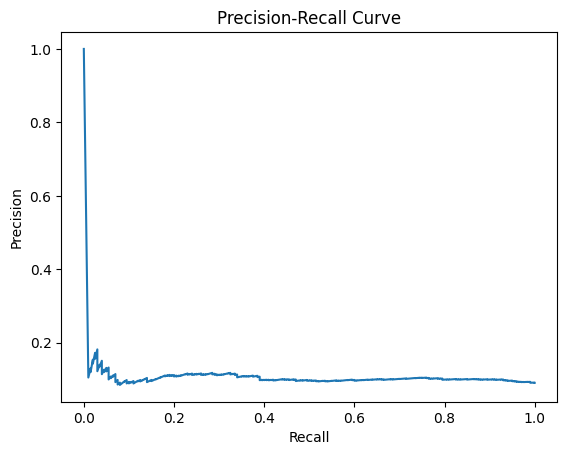

In [30]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities for the test set
y_pred = model.predict(test_data)

# Get the true labels for the test set
y_true = np.concatenate([y for x, y in test_data], axis=0)

# Calculate the fpr, tpr, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_true.ravel(), y_pred.ravel())

# Calculate the precision, recall, and thresholds for the P-R curve
precision, recall, thresholds = precision_recall_curve(y_true.ravel(), y_pred.ravel())

# Calculate the AUC for the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot the P-R curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


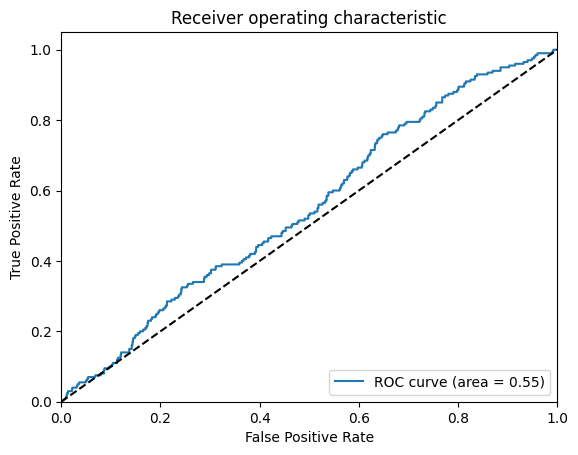

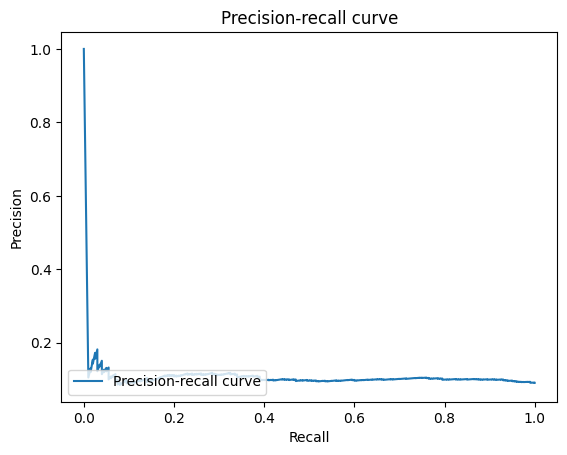

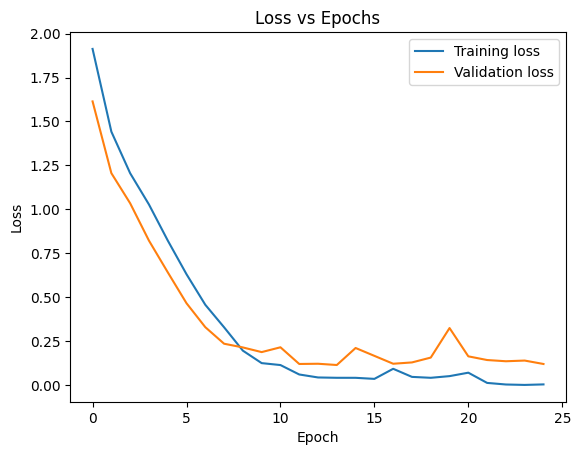

In [31]:
import matplotlib.pyplot as plt

# Plot the AUC-ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.legend(loc="lower left")
plt.show()

# Plot the loss vs epochs for the training and validation sets
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend(loc="upper right")
plt.show()


# Commands TensorFlowJS

In [ ]:
# Save the model
model.save('fruit10_classification_model.h5')

In [ ]:
!pip install tensorflowjs


In [ ]:
!tensorflowjs_converter --input_format keras fruit10_classification_model.h5 tfjs_model